# Compare gridded and microcat ds

- make sure they cover same time period
- select only points in gridded product where I have no NaNs in microcat data
- plot to compare

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date
import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [3]:
# gridded
file_name = "data/Rockall-Trough-Mooring-Time-Series-2020.nc"
ds = xr.open_dataset(file_name)

ds.coords['DEPTH'] = ds.PRES

ds = ds[['TG_EAST', 'TG_WEST']]

# for TG_EAST
ds['TG_EAST_C'] = ds.TG_EAST-273.15
ds.TG_EAST_C.attrs = ds.TG_EAST.attrs 
ds.TG_EAST_C.attrs['units'] = 'degC'
ds.TG_EAST_C.attrs

# and TG_WEST
ds['TG_WEST_C'] = ds.TG_WEST-273.15
ds.TG_WEST_C.attrs = ds.TG_WEST.attrs 
ds.TG_WEST_C.attrs['units'] = 'degC'
ds.TG_WEST_C.attrs;

ds1D = ds.resample(TIME = "1D").mean(keep_attrs=True);

## split it up into east and west dataset

ds_ebg = ds1D[['TG_EAST_C']]
ds_wbg = ds1D[['TG_WEST_C']]

In [35]:
# microcat
file_name = "data/rteb_all_1D.nc"
ds_eb = xr.open_dataset(file_name)
ds_eb = ds_eb.rename({'depth':'DEPTH','time':'TIME'})

# is this how I am supposed to use the mask?
ds_eb = ds_eb.where(ds_eb.mask)

file_name = "data/rtwb_1D.nc"
ds_wb = xr.open_dataset(file_name)
ds_wb = ds_wb.rename({'depth':'DEPTH','time':'TIME'})

In [36]:
depth_EB = np.array(ds_eb.DEPTH).astype(int)
depth_WB = np.array(ds_wb.DEPTH).astype(int)

# Mask

In [44]:
mask = ds_ebg.where(ds_eb.temp != 0)
ds_ebg.coords['mask'] = mask.mask

In [51]:
## why does it not work here?

bla = ds_wbg.where(ds_wb.temp != 0)
#ds_ebg.coords['mask'] = mask.mask

In [52]:
bla

<xarray.Dataset>
Dimensions:    (DEPTH: 5, TIME: 2282)
Coordinates:
  * DEPTH      (DEPTH) float64 100.0 500.0 1e+03 1.5e+03 1.6e+03
  * TIME       (TIME) datetime64[ns] 2014-07-17 2014-07-18 ... 2020-10-14
Data variables:
    TG_WEST_C  (TIME, DEPTH) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/24)
    title:                         CLASS Rockall Trough mooring data 06/2014-...
    institution:                   Scottish Association for Marine Science, S...
    history:                       Delayed time processed quality controlled
    id:                            Rockall-Trough-Mooring-Time-Series-2020
    source:                        subsurface mooring
    project:                       Climate Linked Atlantic Sector Science
    ...                            ...
    citation:                      These data were collected and made freely ...
    acknowledgement:               Funding source: the UK Natural Environment...
    date_created:                  2021-04-15T23:49:44Z
    date_modified:                 2021-04-15T23:49:44Z
    processing_level:              
    QC_indicator:

In [ ]:
ds_wbg.TG_WEST_C.sel(DEPTH=ds_wb.DEPTH, method='nearest').where(ds_wbg.mask).plot.line(x='TIME', figsize=(20,5));

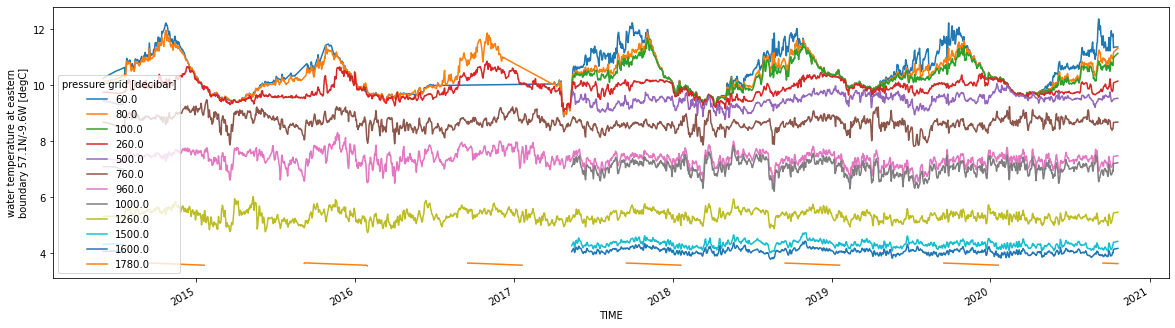

In [39]:
ds_ebg.TG_EAST_C.sel(DEPTH=ds_eb.DEPTH, method='nearest').where(ds_ebg.mask).plot.line(x='TIME', figsize=(20,5));

# Functions

In [26]:
def MHW_func (data, depth, climP=[2014.0,2020.0], altClim=False):
    yy_start = int(data.TIME[0].dt.year)
    yy_end = int(data.TIME[-1].dt.year)
    mm_start = int(data.TIME[0].dt.month)
    mm_end = int(data.TIME[-1].dt.month)
    dd_start = int(data.TIME[0].dt.day)
    dd_end = int(data.TIME[-1].dt.day)
    
    t = np.arange(
        date(yy_start, mm_start, dd_start).toordinal(),                 # .toordinal turns the date into a number that the algorithm can process
        date(yy_end, mm_end, dd_end).toordinal()+1,1) 
    
    temp = data.sel(DEPTH=depth, method = 'nearest').squeeze().values   # by using .squeeze().values we are first removing any other depth and then turning the data into a 1d numpy array 
                                                                        # without doing this the data will still be in an array and the algorithm can't handle it
    
    mhws, clim = mhw.detect(t, temp, climatologyPeriod=climP, alternateClimatology=altClim)                                    # using the algorithm
    mcss, clim_cold = mhw.detect(t, temp, coldSpells = True, climatologyPeriod=climP, alternateClimatology=altClim)            # cold spells 
    return mhws, mcss, clim, clim_cold, t, temp  

In [27]:
def DICT_func(data, depth): 
    mhws_,mcss_,clim_,clim_cold_,t_,temp_ = {},{},{},{},{},{}
    
    for n in depth:
        mhws, mcss, clim, clim_cold, t, temp = MHW_func(data, n) 
        mhws_.update({str(n):mhws})
        mcss_.update({str(n):mcss})
        clim_.update({str(n):clim})
        clim_cold_.update({str(n):clim_cold})
        t_.update({str(n):t})
        temp_.update({str(n):temp})
    
    dictionary = {'mhws':mhws_,'mcss':mcss_,'clim':clim_,'clim_cold':clim_cold_,'t':t_,'temp':temp_}
    return dictionary

In [28]:
def OV_stacked_events(dict, n):
    
    #defining my variables
    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]
        
    ev = (mhws['n_events'])
    ec = (mcss['n_events'])

    fig, ax = plt.subplots(figsize=(30,3),frameon=False)
    plt.subplot(1,1,1)

    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.axvspan(xmin=dates[t1], xmax=dates[t2],color='deeppink')

    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        plt.axvspan(xmin=dates[tc1], xmax=dates[tc2],color='darkcyan')
        
    # Plot t, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, clim['thresh'], ':r', linewidth=0.1, label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', linewidth=0.1, label = 'Threshold cold')
    plt.plot(dates, temp, 'k', linewidth=.1, label = 'Temperature')
    plt.plot(dates, clim['seas'], 'b', linewidth=.1, label = 'Climatology')
    
    if n == 50.0:
        plt.title('Marine Heatwaves and Cold Spells')
    
    plt.xlim(date(2014,7,15), date(2020,10,20))
    plt.grid()
    plt.ylabel(str(n));

# Create Dictionaries

In [31]:
EB_grid = DICT_func(ds1D.TG_EAST_C, depth_EB)
#WB_grid = DICT_func(ds1D.TG_WEST_C, depth_WB)

EB_mcat = DICT_func(ds_eb.temp, depth_EB)
WB_mcat = DICT_func(ds_wb.temp, depth_WB)

## fix clim 
for gridded data at EB, 2017 knock-down event

In [ ]:
temp_100_orig = EB_grid['temp']['100']
clim_100_orig = EB_grid['clim']['100']
dsNC = xr.concat([ds1D.sel(TIME = slice('2014-6-1', '2016-5-31')), ds1D.sel(TIME = slice('2017-6-1', '2020-5-31'))],dim='TIME')

# alternative timeline
t_alt = np.concatenate((np.arange(
        date(2014,6,1).toordinal(),
        date(2016,5,31).toordinal()+1,1), 
        np.arange(
        date(2017,6,1).toordinal(),
        date(2020,5,31).toordinal()+1,1)))

# alternative temperature
temp_alt = dsNC.TG_EAST_C.sel(DEPTH=100).squeeze().values 
temp_100 = ds1D.TG_EAST_C.sel(DEPTH=100)
temp_100 = temp_100.where((temp_100.TIME<np.datetime64('2016-12-10')) | (temp_100.TIME>np.datetime64('2017-05-17'))).squeeze().values

EB_grid['temp']['100'] = temp_100
t_100 = EB_grid['t']['100']

mhws_alt, clim_alt = mhw.detect(t_100,temp_100,climatologyPeriod= [2014.0, 2020.0],alternateClimatology=[t_alt,temp_alt])
EB_grid['mhws']['100'] = mhws_alt
EB_grid['clim']['100'] = clim_alt

mcss_alt, clim_cold_alt = mhw.detect(t_100,temp_100,climatologyPeriod= [2014.0, 2020.0],alternateClimatology=[t_alt,temp_alt], coldSpells=True)
EB_grid['mcss']['100'] = mcss_alt
EB_grid['clim_cold']['100'] = clim_cold_alt